In [1]:
import pyspark as ps
spark = (ps.sql.SparkSession.builder 
        .master("local[1]") 
        .appName("review body") 
        .getOrCreate()
        )
sc = spark.sparkContext

In [2]:
df = spark.read.csv('data/*', sep='\t', header=True)
df.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: string (nullable = true)
 |-- helpful_votes: string (nullable = true)
 |-- total_votes: string (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)



In [3]:
import re
def get_keyval(row):
     # get the text from the row entry
    text=''
    rating=0
    try:
#         if row.review_headline is None: 
        text=row.review_body.lower()
        rating=int(row.star_rating)
    except:
        print(row)
    bl=["a", "an", "on", "of", "or", "as", "i", "in", "is", "to", "the", "and", "for", "with", "not", "by", "this"]
    #lower case text and split by space to get the words
    words=re.findall(r'\b(?!{0}\b)\w+'.format('|'.join(bl)), text) 
    #for each word, send back a count of 1
    #send a list of lists
    return [[w, {'count':1,'rating':rating}] for w in words]

In [4]:
def count_df_column(texts):
    mapped_rdd = texts.rdd.flatMap (lambda row: get_keyval (row))
    counts_rdd = mapped_rdd.reduceByKey(lambda a,b:{'count':(a['count']+b['count']),'rating':(a['rating']+b['rating'])/2.0})
    word_count = counts_rdd.collect()
    word_count.sort(key = lambda x: x[1]['count'])  
    return word_count

In [6]:
texts=df.select(['review_body','star_rating'])
wc=count_df_column(texts)

In [9]:
# %load functions.py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
import matplotlib.cm as cm

def plot_count_rating(words,ratings,counts):
    labels = words
    men_means = ratings
    women_means = counts

    x = np.arange(len(words))  # the label locations
    width = 0.35  # the width of the bars

    # Get a color map
    my_cmap = cm.get_cmap('Greens')

    # Get normalize function (takes data in range [vmin, vmax] -> [0, 1])
    my_norm = Normalize(vmin=1, vmax=5)

    fig, ax = plt.subplots(figsize=(16,9))
    # rects1 = ax.bar(x - width/2, men_means, width, label='Rating')
    rects2 = ax.bar(x + width/2, women_means, width, label='Ratings',color=my_cmap(my_norm(men_means)))

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Counts')
    ax.set_title('Word by rating and count')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    # autolabel(rects1)
    autolabel(rects2)
    fig.tight_layout()

    plt.show()

In [11]:
[words,numbers]=list(zip(*wc[-50:]))
[counts,ratings]=list(zip(*map(lambda x: (x['count'],x['rating']),numbers)))

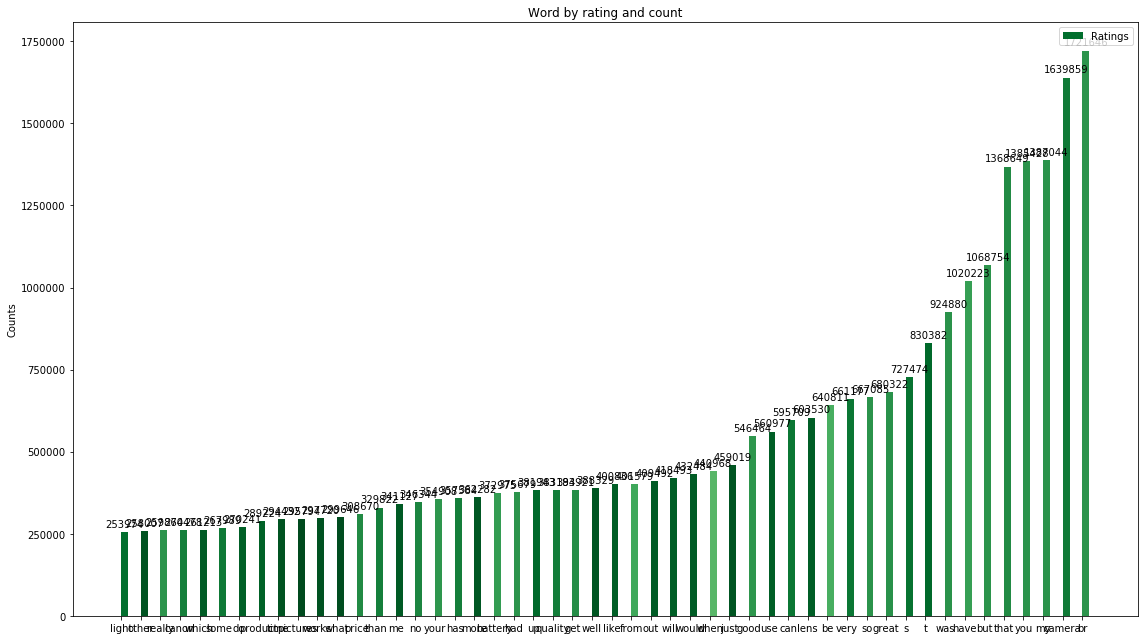

In [12]:
plot_count_rating(words,ratings,counts)

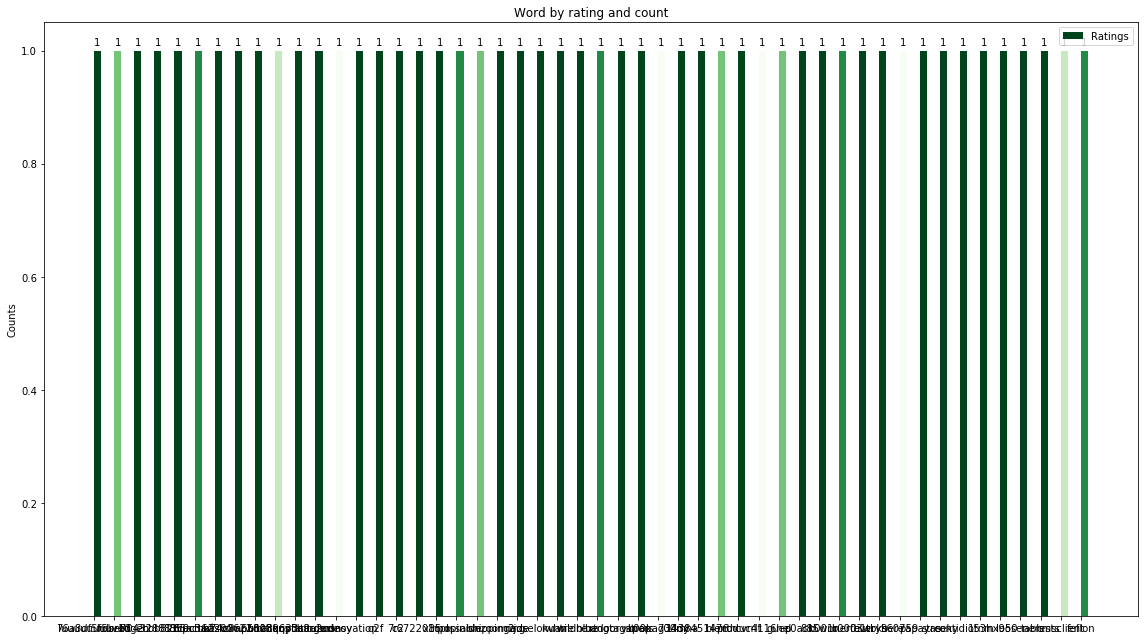

In [14]:
[words,numbers]=list(zip(*wc[:50]))
[counts,ratings]=list(zip(*map(lambda x: (x['count'],x['rating']),numbers)))
plot_count_rating(words,ratings,counts)